# Load the necessary packages

In [1]:
#Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform

#Matplotlib
import matplotlib.pyplot as plt
import numpy as np

#For image processing and the Dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

#CSV and File management
import os
import pandas as pd

#Display matplotlib within jupyter notebook
plt.ion()

In [2]:
data_folder = os.path.join(os.getcwd(), "data")

train_df = pd.read_csv(os.path.join(data_folder, "Train.csv"))
test_df  = pd.read_csv(os.path.join(data_folder, "Test.csv" ))

# The following cell plots all Pokemon of a given Pokedex number, specified from a csv dataframe

Note: it also returns a dataframe of the specified pokemon and their labels + dexnum

[9, 10, 11]
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


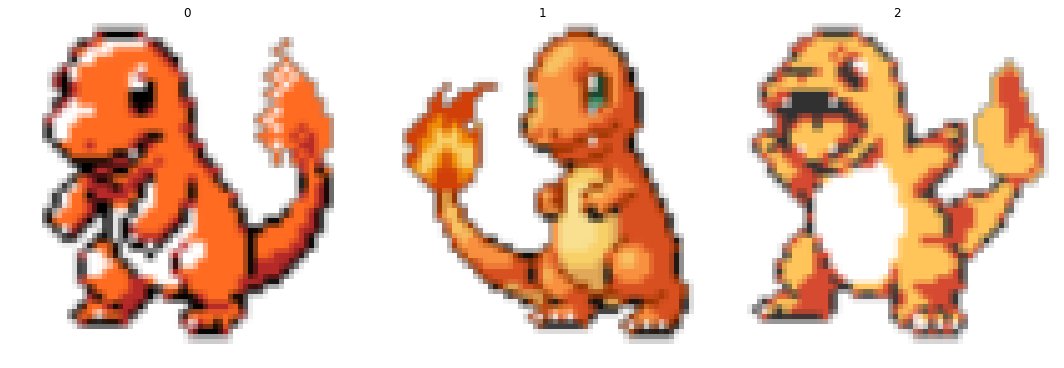

                                              pokemon dex_number normal  \
9   /home/tariq/PokemonTypeNN/data/gsc/charmander.png          4      0   
10  /home/tariq/PokemonTypeNN/data/rse/charmander.png          4      0   
11  /home/tariq/PokemonTypeNN/data/rby/charmander.png          4      0   

   fighting flying poison ground rock bug ghost steel fire water grass  \
9         0      0      0      0    0   0     0     0    1     0     0   
10        0      0      0      0    0   0     0     0    1     0     0   
11        0      0      0      0    0   0     0     0    1     0     0   

   electric psychic ice dragon dark fairy  
9         0       0   0      0    0     0  
10        0       0   0      0    0     0  
11        0       0   0      0    0     0  


In [3]:
def plot_all(dex_num, df):

    df_idxs = [i for i in range(0,len(df)) if df["dex_number"].iloc[i] == dex_num]
    print(df_idxs)
    fig = plt.figure(figsize=(15,15))
    labels = pd.DataFrame(columns=list(df))
    
    for i in range(0, len(df_idxs)):
        
        ax = plt.subplot(1, len(df_idxs), i+1)
        plt.tight_layout()
        ax.set_title(i)
        ax.axis("off")
        pkm_image = io.imread(df["pokemon"].iloc[ df_idxs[i] ])
        plt.imshow(pkm_image)
        print(np.array(pkm_image).shape)
        labels = labels.append(df.iloc[ df_idxs[i]])

    plt.show()
    return labels

#plot an example
temp_labels = plot_all(4,train_df)
print(temp_labels)

# Create the PokemonDataset (loads the project's Train/Test.csv formats)

inspiration: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [108]:
#TODO: Figure out how matrices are fed into pytorch

class PokemonDataset(Dataset):
    """Pokemon Dataset. """
    
    def __init__(self, csv_file_loc, transform=None):
        """
        Args:
            csv_file_loc (string): Path to the csv file
            transform (callable, optional): Optional transform to be applied to the sample
        
        """
        self.df = pd.read_csv(csv_file_loc)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df["pokemon"].iloc[index]
        
        image = io.imread(img_name)
        
        labels = self.df.iloc[index, 2:].as_matrix()
        #TODO: Do I need to reshape the labels?? Following makes labels a column instead of a row
        labels = labels.astype("float").reshape(len(labels))
        sample = {"image": image, "labels": labels}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, index
    
    def getpokemon(self, index):
        return self.df["pokemon"].iloc[index]

# Create Transformation Classes

In [109]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, labels = sample["image"], sample["labels"]
        
        #swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image),
                "labels": torch.from_numpy(labels)}

# Load the Pokemon Datasets for the Neural Network

In [125]:
trainset = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Train.csv"),
                         transform = transforms.Compose([ToTensor()]))
testset  = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Test.csv" ),
                         transform = transforms.Compose([ToTensor()]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=True,  num_workers=2)
testloader  = torch.utils.data.DataLoader(testset , batch_size=16,
                                         shuffle=False, num_workers=2)

classes = list(train_df)[2:]
print(classes)

['normal', 'fighting', 'flying', 'poison', 'ground', 'rock', 'bug', 'ghost', 'steel', 'fire', 'water', 'grass', 'electric', 'psychic', 'ice', 'dragon', 'dark', 'fairy']


# Test with some Training Images

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


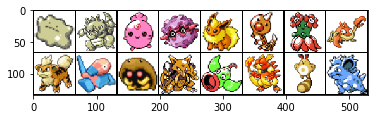

In [126]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#get some random training images
dataiter = iter(trainloader)
minibatch, index = dataiter.next()
images, labels = minibatch["image"], minibatch["labels"]

#show images
imshow(torchvision.utils.make_grid(images))


# Define a Convolutional Neural Network!

In [130]:
# 
# check for multi-classification: https: //stackoverflow.com/questions/52855843/multi-label-classification-in-pytorch
# check for explanation of NN parameters: https://www.aiworkbox.com/lessons/how-to-define-a-convolutional-layer-in-pytorch
# check for reference model: https://nextjournal.com/gkoehler/pytorch-mnist
# loss function: BCELoss
# use sigmoid for multiple classes?

# Use THIS PAGE to calculate matrix outputs: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

# goal: convolve -> ReLu -> pool -> convolve -> ReLu -> pool -> Linear -> ReLu -> Linear -> ReLu -> Linear -> Sigmoid
# Loss function: BCELoss

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #in_channels = number of colors (3), out_channels are the desired number to be learned, and 
        #kernel_size says whether to use nearby pixels  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size = 5, stride=2)
        self.fc1 = nn.Linear(in_features = 108, out_features= 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 18)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
#         print(x.shape)
#         x = x.view(-1, 12*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
net = Net()
#net.cuda()

# Define a loss function and an optimizer

In [131]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the Network

In [132]:
max_epochs = 40

for epoch in range(max_epochs):
    
    running_loss = 0.0
    
    for i, (minibatch, index) in enumerate(trainloader):
        #get the inputs
        images, labels = minibatch["image"], minibatch["labels"]
        #images = images.type("torch.FloatTensor")
        images = images.float()
        labels = labels.float()
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(images) #net.forward()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i %40 == 39: #print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 40))
            running_loss = 0.0
            

print("Finished training")

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[1,    40] loss: 0.314


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[2,    40] loss: 0.267


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[3,    40] loss: 0.266


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[4,    40] loss: 0.263


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[5,    40] loss: 0.258


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[6,    40] loss: 0.249


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[7,    40] loss: 0.246


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[8,    40] loss: 0.233


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[9,    40] loss: 0.226


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[10,    40] loss: 0.214


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[11,    40] loss: 0.205


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[12,    40] loss: 0.197


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[13,    40] loss: 0.181


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[14,    40] loss: 0.171


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[15,    40] loss: 0.159


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[16,    40] loss: 0.144


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[17,    40] loss: 0.135


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[18,    40] loss: 0.118


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[19,    40] loss: 0.112


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[20,    40] loss: 0.097


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[21,    40] loss: 0.082


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[22,    40] loss: 0.071


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[23,    40] loss: 0.066


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[24,    40] loss: 0.057


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[25,    40] loss: 0.042


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[26,    40] loss: 0.038


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[27,    40] loss: 0.029


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[28,    40] loss: 0.030


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[29,    40] loss: 0.033


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[30,    40] loss: 0.023


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[31,    40] loss: 0.036


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[32,    40] loss: 0.037


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[33,    40] loss: 0.020


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[34,    40] loss: 0.012


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[35,    40] loss: 0.010


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[36,    40] loss: 0.006


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[37,    40] loss: 0.004


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[38,    40] loss: 0.002


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[39,    40] loss: 0.001


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[40,    40] loss: 0.001
Finished training


# Test the Network

In [133]:
class_correct = list(0. for i in range(18))
correct_pokemon = []

with torch.no_grad():
    for i, (minibatch, index) in enumerate(testloader):
        images, labels = minibatch["image"], minibatch["labels"]
        images = images.float()
        labels = labels.float()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(images.shape[0]):
            print(testset.getpokemon(index.numpy()[j])," \'s type:: ", classes[predicted[j]])
            if(labels.numpy()[j][predicted[j]] == 1):
                class_correct[predicted[j]] = class_correct[predicted[j]]+1
                correct_pokemon.append(testset.getpokemon(index.numpy()[j]))
                
print("Neural Network's accuracy :: ", sum(class_correct)/testset.__len__())
print("Random Guess accuracy :: ", (1/18))


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


/home/tariq/PokemonTypeNN/data/rse/treecko.png  's type::  ground
/home/tariq/PokemonTypeNN/data/rse/grovyle.png  's type::  ground
/home/tariq/PokemonTypeNN/data/rse/sceptile.png  's type::  psychic
/home/tariq/PokemonTypeNN/data/rse/torchic.png  's type::  water
/home/tariq/PokemonTypeNN/data/rse/combusken.png  's type::  normal
/home/tariq/PokemonTypeNN/data/rse/blaziken.png  's type::  fire
/home/tariq/PokemonTypeNN/data/rse/mudkip.png  's type::  water
/home/tariq/PokemonTypeNN/data/rse/marshtomp.png  's type::  electric
/home/tariq/PokemonTypeNN/data/rse/swampert.png  's type::  flying
/home/tariq/PokemonTypeNN/data/rse/poochyena.png  's type::  normal
/home/tariq/PokemonTypeNN/data/rse/mightyena.png  's type::  flying
/home/tariq/PokemonTypeNN/data/rse/zigzagoon.png  's type::  bug
/home/tariq/PokemonTypeNN/data/rse/linoone.png  's type::  normal
/home/tariq/PokemonTypeNN/data/rse/wurmple.png  's type::  normal
/home/tariq/PokemonTypeNN/data/rse/silcoon.png  's type::  psychic
/

In [124]:
for pkm in correct_pokemon:
    print(pkm)

/home/tariq/PokemonTypeNN/data/rse/mudkip.png
/home/tariq/PokemonTypeNN/data/rse/swampert.png
/home/tariq/PokemonTypeNN/data/rse/lombre.png
/home/tariq/PokemonTypeNN/data/rse/seedot.png
/home/tariq/PokemonTypeNN/data/rse/swellow.png
/home/tariq/PokemonTypeNN/data/rse/wingull.png
/home/tariq/PokemonTypeNN/data/rse/surskit.png
/home/tariq/PokemonTypeNN/data/rse/masquerain.png
/home/tariq/PokemonTypeNN/data/rse/nincada.png
/home/tariq/PokemonTypeNN/data/rse/skitty.png
/home/tariq/PokemonTypeNN/data/rse/medicham.png
/home/tariq/PokemonTypeNN/data/rse/roselia.png
/home/tariq/PokemonTypeNN/data/rse/swalot.png
/home/tariq/PokemonTypeNN/data/rse/wailmer.png
/home/tariq/PokemonTypeNN/data/rse/spoink.png
/home/tariq/PokemonTypeNN/data/rse/grumpig.png
/home/tariq/PokemonTypeNN/data/rse/trapinch.png
/home/tariq/PokemonTypeNN/data/rse/barboach.png
/home/tariq/PokemonTypeNN/data/rse/whiscash.png
/home/tariq/PokemonTypeNN/data/rse/claydol.png
/home/tariq/PokemonTypeNN/data/rse/castformrainy.png
/home

In [32]:
# Test the train/test loader

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].size(), sample["labels"].size())
    
    if(i == 3):
        break


0 torch.Size([3, 64, 64]) torch.Size([1, 18])
1 torch.Size([3, 64, 64]) torch.Size([1, 18])
2 torch.Size([3, 64, 64]) torch.Size([1, 18])
3 torch.Size([3, 64, 64]) torch.Size([1, 18])


/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
dic = {"a":[1,2,3,4],"b": "led", "c":10}
x, y, z = dic
print(x)

a


# Test the PokemonDataset

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
1 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
2 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
3 (64, 64, 4) (1, 18)
[[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


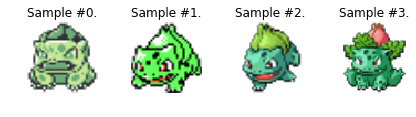

In [71]:
fig = plt.figure()

for i in range(len(trainset)):
    sample = trainset[i]
    
    print(i, sample["image"].shape, sample["labels"].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}.".format(i))
    ax.axis("off")
    plt.imshow(sample["image"])
    print(sample["labels"])
    
    if i == 3:
        plt.show()
        break